<a href="https://colab.research.google.com/github/dhkim0821/Cheetah-Vision-Realsense/blob/master/hw11_soln-test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[Optional] HW 11. Single Leg Robot**

The goal of HW 11 is to control underactuated single leg robot and let it move up and down using whole-body controller. 

<img src="https://github.com/DARoSLab/CS403-Intro-Robotics/blob/main/hws/hw8/3DoF_Arm_Kinematics.png?raw=true" height="400">

In [37]:
!pip3 install sympy seaborn ffmpeg-python qpsolvers casadi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [77]:
import sympy as sym
from sympy import Symbol, simplify, lambdify
from sympy.matrices.expressions import transpose
from sympy import sin, cos, Matrix
import numpy as np
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import animation
%matplotlib inline


# Declare Symbolic Variables

In [78]:
# Write your code: Symbolic variable definition. Complete the following variable list
[M, m1, m2, m3, I, I1, I2, I3, l0, l1, l2, l3, c1, c2,c3,g] = sym.symbols('M m1 m2 m3 I I1 I2 I3 l0 l1 l2 l3 c1 c2 c3 g')
[x, y, thb, th1, th2, th3, dx, dy, dthb, dth1, dth2, dth3, ddx, ddy, ddthb, ddth1, ddth2, ddth3] = sym.symbols('x y thb th1 th2 th3 dx dy dthb dth1 dth2 dth3 ddx ddy ddthb ddth1 ddth2 ddth3')
[tau1, tau2, tau3] = sym.symbols('tau1 tau2 tau3')

# Symbolic variable groupings: No need to change
q  = Matrix([x, y, thb, th1,  th2, th3])
dq = Matrix([dx, dy, dthb, dth1, dth2, dth3])
ddq= Matrix([ddx, ddy, ddthb, ddth1, ddth2, ddth3])
u  = Matrix([tau1, tau2, tau3]) # control input
z = Matrix([q.transpose(), dq.transpose()]) # state
p   = [M, m1, m2, m3, I, I1, I2, I3, l0, l1, l2, l3, c1, c2, c3, g]  # parameters

zp_params = list(z)+list(p)
zup_params = list(z)+list(u)+list(p)

# Parameters: No need to change
M_p  = 3.
m1_p = 1.5
m2_p = 1.
m3_p = 2.0
l0_p = .3
l1_p = .6
l2_p = .6
l3_p = .5
c1_p = .3
c2_p = .2
c3_p = .4
I_p = 0.01
I1_p = 0.005
I2_p = 0.005
I3_p = 0.009
g_p  = 9.81
    
params   = [M_p, m1_p, m2_p, m3_p, I_p, I1_p, I2_p, I3_p, l0_p, l1_p, l2_p, l3_p, c1_p, c2_p, c3_p, g_p]

In [79]:
# Handy functions to be used to compute time derivative and generalized forces: No need to change
ddt = lambda x: x.jacobian(q)@dq + x.jacobian(dq)@ddq        # Time derivative
F2Q = lambda F, r : simplify(r.jacobian(q).transpose()*F)    # force contributions to generalized forces
M2Q = lambda M, w : simplify(w.jacobian(dq).transpose()*M)   # moment contributions to generalized forces

# **Q.1. [25 pts] Kinemeatics**

Complete the code to compute the positions and velocities of the points of interest. Here, all positions and velocities (angular and linear) should be defined to compute kinetic and potential energies.

In [85]:
# Kinemeatics
r0 = Matrix([x, y])    # position of link 1
ehat1 = Matrix([sin(thb), -cos(thb)]) # Define unit vector along Leg 1
ehat2 = Matrix([sin(thb+th1), -cos(thb+th1)])  # Define unit vector along Leg 2
ehat3 = Matrix([sin(thb+th1+th2), -cos(thb+th1+th2)])  # Define unit vector along Leg 2
ehat4 = Matrix([cos(thb+th1+th2+th3), sin(thb+th1+th2+th3)])  # Define unit vector along Leg 2
ehat5 = -ehat4  # Define unit vector along Leg 2
ghat  = Matrix([0, -1 ])                       

# Write your code: Define CoM position and link position
rA  = r0 + l0*ehat1          # Position of base of link 2
rB  = rA + l1*ehat2     # Position of end of link 3
rC  = rB + l2*ehat3     # Position of end of link 3
rD  = rC + 0.5*l3*ehat4     # Position of Heel
rE  = rC + 0.5*l3*ehat5     # Position of Toe

rcb  = r0 # COM of base 
rc1 = rA + c1*ehat2          # Position of link 1 CoM
rc2 = rB + c2*ehat3     # Position of CoM of link 2
rc3 = rC     # Position of CoM of link 3


# Write your code: Define linear and angular velocity of each link
# Hint: Utilize 'ddt' function

vcb = ddt(rcb) 
vc1 = ddt(rc1)          # Velocity of link 1 CoM
vc2 = ddt(rc2)          # Velocity of link 2 CoM
vc3 = ddt(rc3)          # Velocity of link 3 CoM

keypoints = Matrix([[r0], [rA], [rB], [rC], [rD], [rE]]).reshape(6, 2)
keypoints_func = sym.lambdify(zp_params, keypoints)

In [83]:
# hopper robot visualization function: 

import matplotlib.patches as patches
def rotate_rect(rect, angle):
    """Rotate the given rectangle around its center and return a rotated copy.

    angle is given in degrees.
    """
    rect = np.array(rect, dtype=np.float64)
    rot_mat = np.array([[np.cos(angle), -np.sin(angle)],
                        [np.sin(angle), np.cos(angle)]])
    rect_rot = np.dot(rot_mat, rect.T).T
    return rect_rot

def get_body_points(x, y, angle, body_width, body_height):
  body_pts = [[-body_width/2, -body_height/2],
              [-body_width/2, body_height/2],
              [body_width/2, body_height/2],
              [body_width/2, -body_height/2]]
  body_pts = rotate_rect(body_pts, angle)
  body_pts_full = np.zeros((5, 2))
  body_pts[:, 0] += x
  body_pts[:, 1] += y
  body_pts_full[:4, :] = body_pts
  body_pts_full[4, :] = body_pts[0]
  return body_pts_full

def visualize_robot(result, dt = 0.001, num_frames=200):
  keypoints_hist = result['keypoints_hist']
  ori_hist = result['ori_hist']
  fig= plt.figure(figsize=(10,10))
  ax = plt.subplot(1,1,1)   
  keypoints = keypoints_hist[0]
  keypts = keypoints_hist[0]
  body_width = 2*np.sqrt((keypts[1, 0] - keypts[0, 0])**2 + (keypts[1, 1] - keypts[0, 1])**2)  
  body_pts = get_body_points(keypts[0, 0], keypts[0, 1], 0.5, body_width, body_width)
  body, = ax.plot(body_pts[:, 0], body_pts[:, 1], 'g', lw=10, alpha=0.3)
  bodyCOM, = ax.plot(keypts[0, 0], keypts[0, 1], 'go', alpha=0.5, markersize=20)
  link2, = ax.plot([], [], 'r', lw=10, alpha=0.3)
  link3, = ax.plot([], [], 'r', lw=10, alpha=0.3)
  link4, = ax.plot([], [], 'b', lw=10, alpha=0.3) 
  ax.hlines(0, -2, 2)
  txt_title = ax.set_title('')
  ax.set_xlim(( -2, 2))            
  ax.set_ylim((-1, 3))
  txt_title = ax.set_title('')
  interval = len(keypoints_hist)//num_frames
  
  def drawFrame(k):
    k = interval*k
    keypts = keypoints_hist[k]
    body_pts = get_body_points(keypts[0, 0], keypts[0, 1], ori_hist[k], body_width, body_width)
    body.set_data(body_pts[:, 0], body_pts[:, 1])
    bodyCOM.set_data(keypts[0, 0], keypts[0, 1])
    x1 = keypts[1, 0]
    x2 = keypts[2, 0]
    y1 = keypts[1, 1]
    y2 = keypts[2, 1]
    link2.set_data([x1, x2], [y1, y2])
    x1 = keypts[2, 0]
    x2 = keypts[3, 0]
    y1 = keypts[2, 1]
    y2 = keypts[3, 1]
    link3.set_data([x1, x2], [y1, y2])
    x1 = keypts[4, 0]
    x2 = keypts[5, 0]
    y1 = keypts[4, 1]
    y2 = keypts[5, 1]
    link4.set_data([x1, x2], [y1, y2])
    
    txt_title.set_text(f't = {dt*k:.2f} sec')
    return link2, link3, link4
  anim = animation.FuncAnimation(fig, drawFrame, frames=num_frames, interval=interval, blit=True)
  return anim


# **Q.2. [20 pts] Kinetic and Potential Energy of Links**

Define the kinetic and potential energy of each link

In [86]:
# Write your code: Kinetic and Potential Energy of floating base

Tb = 1/2 * M * vcb.dot(vcb) + 1/2 * I * dthb*dthb
Vb = M * g * (rcb.dot(-ghat))

# Write your code: Kinetic and Potential Energy of link 1

T1 = 1/2 * m1 * vc1.dot(vc1) + 1/2 * I1 * (dthb+dth1)*(dthb+dth1)
V1 = m1 * g * (rc1.dot(-ghat))

# Write your code: Kinetic and Potential Energy of link 2
T2 = 1/2 * m2 * vc2.dot(vc2) + 1/2 * I2 * (dthb+dth1+dth2)*(dthb+dth1+dth2)
V2 = m2 * g * rc2.dot(-ghat)

# Write your code: Kinetic and Potential Energy of link 3
T3 = 1/2 * m3 * vc3.dot(vc3) + 1/2 * I3 * (dthb+dth1-dth2+dth3)*(dthb+dth1+dth2+dth3)
V3 = m3 * g * rc3.dot(-ghat)


# **Q.3. [15 pts] Lagrangian and Total Energy (Hamiltonian)**

In [87]:
# Write your code: Kinetic, Potential, and total energy of the entire system
KE = Tb + T1 + T2 + T3
PE = Vb + V1 + V2 + V3
E = Matrix([KE + PE])

# Write your code: Lagrangian
L = Matrix([KE - PE])

# **Q.3. [20 pts] Generalized Forces**

Define generalized force vectors using a M2Q function. 

Hint: The result should be $Q = \begin{pmatrix}\tau_1 \\ \tau_2 \\ \tau_3\end{pmatrix}$. 

In [88]:
Q_tau1 = M2Q(tau1,Matrix([dthb + dth1])) + M2Q(-tau1,Matrix([dthb])) 
Q_tau2 = M2Q(tau2,Matrix([dth2 + dth1 + dthb])) + M2Q(-tau2, Matrix([dth1 + dthb]))
Q_tau3 = M2Q(tau3,Matrix([dth3 + dth2 + dth1 + dthb])) + M2Q(-tau3, Matrix([dth1 + dth2 + dthb]))

Q = Q_tau1 + Q_tau2 + Q_tau3

print(Q_tau1)
print(Q_tau2)
print(Q_tau3)

print(Q)

Matrix([[0], [0], [0], [tau1], [0], [0]])
Matrix([[0], [0], [0], [0], [tau2], [0]])
Matrix([[0], [0], [0], [0], [0], [tau3]])
Matrix([[0], [0], [0], [tau1], [tau2], [tau3]])


# **Q.4. [10 pts] Equations of Motion**

Complete the equations of motion by applying Lagrange formula. Find A (Mass matrix) and b vector explained in the lecture.

In [89]:
# Write your code: Find A and b by solving Lagrange's equation
dL_dq = L.jacobian(q).transpose()
dL_dqd= L.jacobian(dq).transpose()

g = ddt(dL_dqd) - dL_dq - Q
A = g.jacobian(ddq)
b = A*ddq - g
grav = (Matrix([PE]).jacobian(q)).transpose()
coriolis = (-b -grav  + Q)

In [92]:
JToe = rD.jacobian(q)
JToedot = ddt(JToe.reshape(12,1)).reshape(2, 6)

JHeel = rE.jacobian(q)
JHeeldot = ddt(JHeel.reshape(12,1)).reshape(2, 6)

pToe = rD
pHeel = rE
vToe = JToe*dq
vHeel = JHeel*dq

In [93]:
print(A)
print(JToe)
print(JToedot)
A
pToe

Matrix([[1.0*M + 1.0*m1 + 1.0*m2 + 1.0*m3, 0, 0.5*m1*(2*c1*cos(th1 + thb) + 2*l0*cos(thb)) + 0.5*m2*(2*c2*cos(th1 + th2 + thb) + 2*l0*cos(thb) + 2*l1*cos(th1 + thb)) + 0.5*m3*(2*l0*cos(thb) + 2*l1*cos(th1 + thb) + 2*l2*cos(th1 + th2 + thb)), 1.0*c1*m1*cos(th1 + thb) + 0.5*m2*(2*c2*cos(th1 + th2 + thb) + 2*l1*cos(th1 + thb)) + 0.5*m3*(2*l1*cos(th1 + thb) + 2*l2*cos(th1 + th2 + thb)), 1.0*c2*m2*cos(th1 + th2 + thb) + 1.0*l2*m3*cos(th1 + th2 + thb), 0], [0, 1.0*M + 1.0*m1 + 1.0*m2 + 1.0*m3, 0.5*m1*(2*c1*sin(th1 + thb) + 2*l0*sin(thb)) + 0.5*m2*(2*c2*sin(th1 + th2 + thb) + 2*l0*sin(thb) + 2*l1*sin(th1 + thb)) + 0.5*m3*(2*l0*sin(thb) + 2*l1*sin(th1 + thb) + 2*l2*sin(th1 + th2 + thb)), 1.0*c1*m1*sin(th1 + thb) + 0.5*m2*(2*c2*sin(th1 + th2 + thb) + 2*l1*sin(th1 + thb)) + 0.5*m3*(2*l1*sin(th1 + thb) + 2*l2*sin(th1 + th2 + thb)), 1.0*c2*m2*sin(th1 + th2 + thb) + 1.0*l2*m3*sin(th1 + th2 + thb), 0], [0.5*m1*(2*c1*cos(th1 + thb) + 2*l0*cos(thb)) + 0.5*m2*(2*c2*cos(th1 + th2 + thb) + 2*l0*cos(thb) 

Matrix([
[ l0*sin(thb) + l1*sin(th1 + thb) + l2*sin(th1 + th2 + thb) + 0.5*l3*cos(th1 + th2 + th3 + thb) + x],
[-l0*cos(thb) - l1*cos(th1 + thb) - l2*cos(th1 + th2 + thb) + 0.5*l3*sin(th1 + th2 + th3 + thb) + y]])

# **Helper Functions For Simulation**

In [94]:
# Helper Functions: No need to change
A_func = sym.lambdify(zp_params, A)
b_func = sym.lambdify(zup_params, b)
kinetic_energy_func = sym.lambdify(zp_params, KE)
potential_energy_func = sym.lambdify(zp_params, PE)
E_func = sym.lambdify(zp_params, E)

grav_func = sym.lambdify(zp_params, grav)
coriolis_func = sym.lambdify(zp_params, coriolis)

# Foot contact position, velocity and jacobian
pToe_func = sym.lambdify(zp_params, pToe)
vToe_func = sym.lambdify(zp_params, vToe)

pHeel_func = sym.lambdify(zp_params, pHeel)
vHeel_func = sym.lambdify(zp_params, vHeel)

JToe_func = sym.lambdify(zp_params, JToe)
JToedot_func = sym.lambdify(zp_params, JToedot)

JHeel_func = sym.lambdify(zp_params, JHeel)
JHeeldot_func = sym.lambdify(zp_params, JHeeldot)


#Q.5. [10 pts] **Dynamics**

Complete the dynamics function returning $\ddot{q}$ by using $A$ and $b$.

In [95]:
def dynamics(x, params, u=[0, 0, 0]):
  
  xp_params = list(x) + list(params)
  xup_params = list(x) + u + list(params)
  A_dyn = A_func(*xp_params)
  b_dyn = b_func(*xup_params)

  # Write your code: Computer joint acceleration
  qdd = np.matmul(np.linalg.pinv(A_dyn), b_dyn)  
  ddq = qdd.reshape(6)

  return ddq

In [245]:
def discrete_impact_contact(x, params, rest_coeff, fric_coeff):
    xp_params = list(x) + list(params)

    x_test = x.copy()
    qdot = x[6:].copy()

    # EE position and velocity
    toe_pos = pToe_func(*xp_params)
    toe_vel = vToe_func(*xp_params)
    heel_pos = pHeel_func(*xp_params)
    heel_vel = vHeel_func(*xp_params)

    iter_lim = 100

    # Toe and heel contact
    if ((toe_pos[1] < 0) and (heel_pos[1]<0)):
      post_impact_vel = np.zeros([4,1])
      post_impact_vel[1] = toe_vel[1]
      post_impact_vel[3] = heel_vel[1]

      if(toe_pos[1]<0.015 and toe_vel[1]<0.04):
         post_impact_vel[1] = 0.04
      if(heel_pos[1]<0.015 and heel_vel[1]<0.04):
         post_impact_vel[3] = 0.04

      Jtoe  = JToe_func(*xp_params)
      Jheel  = JHeel_func(*xp_params)

      A = A_func(*xp_params)
      Ainv = np.linalg.inv(A)
      
      Jtoe_x = Jtoe[0, :]
      Jtoe_y = Jtoe[1, :]
      Jheel_x = Jheel[0,:]
      Jheel_y = Jheel[1,:]

      lambda_toe_x = 1/(Jtoe_x @ Ainv @ Jtoe_x.T)
      lambda_toe_y = 1/(Jtoe_y @ Ainv @ Jtoe_y.T)

      lambda_heel_x = 1/(Jheel_x @ Ainv @ Jheel_x.T)
      lambda_heel_y = 1/(Jheel_y @ Ainv @ Jheel_y.T)

      Ftoe_x_total = 0
      Ftoe_y_total = 0

      Fheel_x_total = 0
      Fheel_y_total = 0


      Ftoe_x_inc = 1000
      Ftoe_y_inc = 1000

      Fheel_x_inc = 1000
      Fheel_y_inc = 1000

      Ftoe_y_min = 0
      Ftoe_y_max = 100000

      Fheel_y_min = 0
      Fheel_y_max = 100000

      iter = 0
      err = 100
      while( err > 1e-5):
        # Vertical (y): Toe
        Ftoe_y_inc = lambda_toe_y * (post_impact_vel[1] - Jtoe_y@qdot)
        next_F_toe_y_total = max(Ftoe_y_min, min(Ftoe_y_total + Ftoe_y_inc, Ftoe_y_max))
        Ftoe_y_inc = next_F_toe_y_total - Ftoe_y_total
        qdot = qdot + Ainv@(Jtoe_y.T*Ftoe_y_inc)
        Ftoe_y_total += Ftoe_y_inc

        # Vertical (y): Heel
        Fheel_y_inc = lambda_heel_y * (post_impact_vel[3] - Jheel_y@qdot)
        next_F_heel_y_total = max(Fheel_y_min, min(Fheel_y_total + Fheel_y_inc, Fheel_y_max))
        Fheel_y_inc = next_F_heel_y_total - Fheel_y_total
        qdot = qdot + Ainv@(Jheel_y.T*Fheel_y_inc)
        Fheel_y_total += Fheel_y_inc
        
        # Horizontal (x): Heel
        Fheel_x_inc = lambda_heel_x * (post_impact_vel[2] - Jheel_x@qdot)
        next_Fheel_x_total = max(-fric_coeff*Fheel_y_total, min(Fheel_x_total + Fheel_x_inc, fric_coeff*Fheel_y_total))
        Fheel_x_inc = next_Fheel_x_total - Fheel_x_total
        
        qdot = qdot + Ainv@(Jheel_x.T*Fheel_x_inc)
        Fheel_x_total += Fheel_x_inc

        # horizontal (x): Toe
        Ftoe_x_inc = lambda_toe_x * (post_impact_vel[0] - Jtoe_x@qdot)
        next_Ftoe_x_total = max(-fric_coeff*Ftoe_y_total, min(Ftoe_x_total + Ftoe_x_inc, fric_coeff*Ftoe_y_total))
        Ftoe_x_inc = next_Ftoe_x_total - Ftoe_x_total
        
        qdot = qdot + Ainv@(Jtoe_x.T*Ftoe_x_inc)
        Ftoe_x_total += Ftoe_x_inc

        # Error
        err = (post_impact_vel[1] - Jtoe_y@qdot)
        err += (post_impact_vel[3] - Jheel_y@qdot)
        err += (post_impact_vel[0] - Jtoe_x@qdot)
        err += (post_impact_vel[2] - Jheel_x@qdot)        

        iter += 1
        if (iter > iter_lim-1):
          print(err)
          print(Jtoe@qdot)
          print(Jheel@qdot)
        
        if(iter > iter_lim):
          break  
      # print(iter)
      # print(err)
      # print(Jtoe@qdot)
      # print(Jheel@qdot)
      # toe_vel = Jtoe@qdot
      # heel_vel = Jheel@qdot
      # print("toe vel:")
      # print(toe_vel)
      # print("heel vel:")
      # print(heel_vel)
      # print(iter)
      # print("\n")

    elif(toe_pos[1]<0): # ............................. Toe 
      # print("toe only")
      post_impact_vel = np.zeros([2,1])
      # post_impact_vel[1] = -rest_coeff*toe_vel[1]
      post_impact_vel[1] = toe_vel[1]
      
      if(toe_vel[1]<0.01):
         post_impact_vel[1] = 0.01
      
      J  = JToe_func(*xp_params)
      A = A_func(*xp_params)
      Ainv = np.linalg.inv(A)
      
      J_x = J[0, :]
      J_y = J[1, :]
      lambda_x = 1/(J_x @ Ainv @ J_x.T)
      lambda_y = 1/(J_y @ Ainv @ J_y.T)



      Fx_total = 0
      Fy_total = 0
      Fx_inc = 1000
      Fy_inc = 1000

      Fy_min = 0
      Fy_max = 100000

      iter = 0
      err = 100
      # while(np.abs(Fx_inc) > 1e-2 or np.abs(Fy_inc) > 1e-2):
      while(err > 1e-5):
        # vertical (y)
        Fy_inc = lambda_y * (post_impact_vel[1] - J_y@qdot)

        next_Fy_total = max(Fy_min, min(Fy_total + Fy_inc, Fy_max))
        Fy_inc = next_Fy_total - Fy_total
        
        qdot = qdot + Ainv@(J_y.T*Fy_inc)
        Fy_total += Fy_inc

        # horizontal (y)
        Fx_inc = lambda_x * (post_impact_vel[0] - J_x@qdot)

        next_Fx_total = max(-fric_coeff*Fy_total, min(Fx_total + Fx_inc, fric_coeff*Fy_total))
        Fx_inc = next_Fx_total - Fx_total
        
        qdot = qdot + Ainv@(J_x.T*Fx_inc)
        Fx_total += Fx_inc
        iter += 1
        
        # Error
        err = (post_impact_vel[1] - J_y@qdot)
        err += (post_impact_vel[0] - J_x@qdot)
        
        if (iter > iter_lim-1):
          print(err)
          print(Jtoe@qdot)
        
        if(iter > iter_lim):
          break
          
    elif(heel_pos[1]<0): # ...................... Heel only contact
      # print("heel only")

      post_impact_vel = np.zeros([2,1])
      # post_impact_vel[1] = -rest_coeff*heel_vel[1]
      post_impact_vel[1] = heel_vel[1]
      
      if(heel_vel[1]<0.01):
         post_impact_vel[1] = 0.01

      J  = JHeel_func(*xp_params)
      A = A_func(*xp_params)
      Ainv = np.linalg.inv(A)
      
      J_x = J[0, :]
      J_y = J[1, :]
      lambda_x = 1/(J_x @ Ainv @ J_x.T)
      lambda_y = 1/(J_y @ Ainv @ J_y.T)

      Fx_total = 0
      Fy_total = 0
      Fx_inc = 1000
      Fy_inc = 1000

      Fy_min = 0
      Fy_max = 100000

      iter = 0
      err = 100
      # while(np.abs(Fx_inc) > 1e-2 or np.abs(Fy_inc) > 1e-2):
      while(err > 1e-5):
        # vertical (y)
        Fy_inc = lambda_y * (post_impact_vel[1] - J_y@qdot)

        next_Fy_total = max(Fy_min, min(Fy_total + Fy_inc, Fy_max))
        Fy_inc = next_Fy_total - Fy_total
        
        qdot = qdot + Ainv@(J_y.T*Fy_inc)
        Fy_total += Fy_inc

        # horizontal (y)
        Fx_inc = lambda_x * (post_impact_vel[0] - J_x@qdot)

        next_Fx_total = max(-fric_coeff*Fy_total, min(Fx_total + Fx_inc, fric_coeff*Fy_total))
        Fx_inc = next_Fx_total - Fx_total
        
        qdot = qdot + Ainv@(J_x.T*Fx_inc)
        Fx_total += Fx_inc

        iter += 1
        
        if (iter > iter_lim-1):
          print(err)
          print(Jtoe@qdot)

        # Error
        err = (post_impact_vel[1] - J_y@qdot)
        err += (post_impact_vel[0] - J_x@qdot)
        
        if(iter > iter_lim):
          break
        # print(iter)

    return qdot

# **Perform Simulation**

In [186]:
def joint_pd_controller(x, xdes, params, Kp=100, Kd=5):
  u = Kp*(xdes[3:6]-x[3:6]) + Kd*(xdes[3+6:]-x[3+6:])
  return u.tolist()

In [190]:
def run_simulation(x0,  x_des_trj, num_step, dt = 0.001,  restitution_coeff = 0.9, friction_coeff = 1.7, ctrl_function = None):
  num_step = int(np.floor(tf/dt));
  tspan = np.linspace(0, tf, num_step); 
  
  x_out = np.zeros((12,num_step+1));
  x_out[:,0] = x0;
  keypoints_hist = []
  kinetic_energy_hist = []
  potential_energy_hist = []
  total_energy_hist = []
  ori_hist = []
  result = {}
  for i in range(num_step):
    xp_params = list(x_out[:, i]) + list(params)
    keypoints_hist.append(keypoints_func(*xp_params))

    u = control_func(x_out[:, i], x_des_trj[:, i], params)

    ddq = dynamics(x_out[:,i], params, u);
    x_out[6:,i+1] = x_out[6:,i] + ddq*dt;
    x = np.zeros(12)
    
    x[:6] = x_out[:6, i]
    x[6:] = x_out[6:, i+1]
    
    x_out[6:, i+1] = discrete_impact_contact(x, params, restitution_coeff, friction_coeff)
    x_out[:6,i+1] = x_out[:6,i] + x_out[6:,i+1]*dt;
    ori_hist.append(x_out[2, i])
    
  result['keypoints_hist'] = keypoints_hist
  result['ori_hist'] = ori_hist
  return result

In [246]:
x0 = np.array([0, 1.2, 0, 0.8, -1.6, 0.8, 0, 0, 0, 0, 0, 0]).T  # x, y, thb, th1, th2, th3, dx, dy, dthb, dth1, dth2, dth3
dt = 0.001
tf = 4.0
num_step = int(np.floor(tf/dt));
ts = np.linspace(0, tf, num_step)

num_step = int(np.floor(tf/dt));
x_des_trj = np.zeros((12, num_step))
x_des_trj[1, :] = x0[1]
x_des_trj[3, :] = x0[3] # Hip
x_des_trj[4, :] = x0[4] # Knee
x_des_trj[5, :] = x0[5] # Ankle


control_func = lambda x, xdes, params : joint_pd_controller(x, xdes, params, Kp=250, Kd=7)

result = run_simulation(x0,  x_des_trj, num_step, dt = dt, restitution_coeff = 0.0, friction_coeff = 0.7, ctrl_function = None)

[4.81211942e-05]
[0.         0.04000023]
[-4.78633519e-05  2.19533389e-01]
[4.81210622e-05]
[0.         0.04000023]
[-4.78633518e-05  2.19533389e-01]
[6.14636954e-05]
[-1.11022302e-16  4.00002401e-02]
[-6.12012613e-05  3.32746024e-01]
[6.14635842e-05]
[0.         0.04000024]
[-6.12012613e-05  3.32746024e-01]
[1.22840723e-05]
[0.         0.04000002]
[-1.22595614e-05  1.63912025e-01]
[1.22840304e-05]
[1.38777878e-17 4.00000220e-02]
[-1.22595614e-05  1.63912025e-01]
[1.14899367e-05]
[2.77555756e-17 4.00000141e-02]
[-1.14740319e-05  2.08654449e-01]
[1.14898921e-05]
[1.38777878e-17 4.00000141e-02]
[-1.14740319e-05  2.08654449e-01]
[1.26750108e-05]
[-1.38777878e-17  4.00000451e-02]
[-1.26249773e-05  1.04508899e-01]
[1.26749484e-05]
[-2.08166817e-17  4.00000451e-02]
[-1.26249773e-05  1.04508899e-01]
[2.76926626e-05]
[2.77555756e-17 4.00000739e-02]
[-2.76111502e-05  2.28950463e-01]
[2.76926119e-05]
[0.         0.04000007]
[-2.76111502e-05  2.28950463e-01]
[1.3244888e-05]
[-2.77555756e-17  4.00

In [247]:
anim = visualize_robot(result, dt = 0.001, num_frames=100)
plt.close()
HTML(anim.to_html5_video())

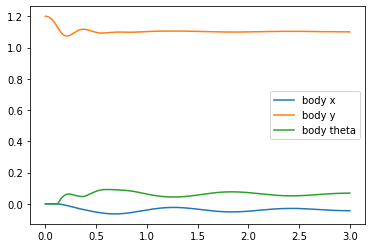

In [103]:
keypoint_hist_np = np.array(result['keypoints_hist'])

print()
ax = plt.subplot()

ax.plot(ts, keypoint_hist_np[:, 0, 0], label='body x')
ax.plot(ts, keypoint_hist_np[:, 0, 1], label='body y')
ax.plot(ts, result['ori_hist'], label='body theta')
ax.legend()
plt.show()

# Wholebody control QP

\begin{align}
& \underset{\ddot{\mathbf{q}}, \mathbf{\tau}, \mathbf{fr}}{min}\  ||\ddot{\mathbf{q}}^{\rm cmd}-\ddot{\mathbf{q}}||_{Q_q} + ||\mathbf{f_r}||_{Q_{fr}} + ||\mathbf{\tau}||_{Q_\tau}\\
s.t & \\
& \mathbf{A}\ddot{\mathbf{q}} + \mathbf{b} + \mathbf{g} = \mathbf{J_c}^{T}\mathbf{f_r} + \mathbf{S}^T\mathbf{\tau}\\ 
&\mathbf{W}\mathbf{f}_r\ge0\\
&\mathbf{\tau}_{min} \le \mathbf{\tau} \le \mathbf{\tau}_{max}\\
\end{align}


In [102]:
from casadi import *

In [181]:
def dyn_psudoInv(J, Ainv):
  lamdainv = J@Ainv@J.T
  lamda = np.linalg.pinv(lamdainv)
  return Ainv@J.T@lamda

def whole_body_controller_qp(x, xdes, params, Kp=100, Kd=5):
  xdd_des = Kp*(xdes[:3]-x[:3]) + Kd*(xdes[3:6]-x[3:6])
  # print(xdd_des)
  xp_params = list(x) + params
  Jt = JToe_func(*xp_params)# toe jacobian
  Jh = JHeel_func(*xp_params) # heel jacobian
  Jc = np.zeros((4, 6)) # contact jacobian
  Jc[:2, :] = Jt
  Jc[2:, :] = Jh
  # print(Jc)
  
  Jbody = np.zeros((3, 6))
  Jbody[:3, :3] = np.eye(3)

  A = A_func(*xp_params)
  cori = coriolis_func(*xp_params)
  grav = grav_func(*xp_params)
  
  Ainv = np.linalg.inv(A)
  # lamdainv = Jc@Ainv@Jc.T
  Nc = np.eye(6) - dyn_psudoInv(Jc, Ainv)@Jc
  JbodyNc = Jbody@Nc
  JbodyNc_bar = dyn_psudoInv(JbodyNc, Ainv)
  qdd_cmd =  JbodyNc_bar @ xdd_des
  
  opti = casadi.Opti()

  qdd = opti.variable(6)
  fr = opti.variable(4)
  tau = opti.variable(3)
  Q_q = np.diag(np.array([100, 100, 1000, 10, 10, 10]))
  Q_fr = np.diag(np.array([0.5, 0.001, 0.5, 0.001]))
  Q_tau = np.diag(np.array([0.05, 0.05, 0.05]))
  ftoe = fr[:2]
  fheel = fr[2:]
  mu = 0.6
  ST = np.zeros((6,3))
  ST[3:, :] = np.eye(3)

  zero_6 = np.zeros(6)
  one_6 = np.ones(6)
  one_3 = np.ones(3)

  # cost we want to minimize
  cost  = (qdd_cmd-qdd).T@Q_q@(qdd_cmd-qdd)
  cost  += fr.T@Q_fr@fr
  cost  += tau.T@Q_tau@tau
  
  opti.minimize(cost)
  #dynamics constraint
  opti.subject_to(A@qdd + cori + grav  == Jc.T@fr + ST@tau) 

  # # normal force
  # opti.subject_to(fr[1] > 0) 
  # opti.subject_to(fr[3] > 0)
  # opti.subject_to(fr[1] <= 60) 
  # opti.subject_to(fr[3] <= 60)

  # # Friction (toe)
  # opti.subject_to(fr[0] <=  mu*fr[1])
  # opti.subject_to(fr[0] >= -mu*fr[1])
  
  # opti.subject_to(fr[2] <= mu*fr[3])
  # opti.subject_to(fr[2] >= -mu*fr[3])
  
  # normal force must be greater than zero
  opti.subject_to(ftoe[1] > 5) 
  opti.subject_to(fheel[1] > 5)
  opti.subject_to(ftoe[1] <= 60) 
  opti.subject_to(fheel[1] <= 60)
  #friction constraints
  opti.subject_to(ftoe[0] <=  mu*ftoe[1])
  opti.subject_to(ftoe[0] >= -mu*ftoe[1])
  
  opti.subject_to(fheel[0] <= mu*fheel[1])
  opti.subject_to(fheel[0] >= -mu*fheel[1])

  opti.subject_to(tau >= -50*one_3)
  opti.subject_to(tau <= 50*one_3)
  
  # p_opts = {"expand":True, 'ipopt.print_level':2, 'print_time':2}
  p_opts = {"expand":True, 'ipopt.print_level':0, 'print_time':0}
  s_opts = {"max_iter": 100}

  opti.solver('ipopt', p_opts, s_opts)
  sol = opti.solve()

  # print(qdd_cmd)
  # print(f"qdd: {sol.value(qdd)}")
  # print(f"tau: {sol.value(tau)}")
  # print(f"fr: {sol.value(fr)}")

  u = sol.value(tau)
  return u.tolist()

In [182]:
x0 = np.array([0, 1.18, 0, 0.8, -1.6, 0.8, 0, 0, 0, 0, 0, 0]).T  # x, y, thb, th1, th2, th3, dx, dy, dthb, dth1, dth2, dth3
dt = 0.001
tf = 0.5
num_step = int(np.floor(tf/dt));
ts = np.linspace(0, tf, num_step)

a = 0.0
omega = 100
x_des_trj = np.zeros((12, num_step))
h0 = 1.18
x_des_trj[0, :] = 0 #a*np.sin(omega*ts)
x_des_trj[1, :] = h0 + a*np.sin(omega*ts)
x_des_trj[2, :] = 0 #a*np.sin(omega*ts)

control_func = lambda x, xdes, params : whole_body_controller_qp(x, xdes, params, Kp=100, Kd=3)
result = run_simulation(x0,  x_des_trj, num_step, dt = dt, restitution_coeff = 0.1, friction_coeff = 1.0, ctrl_function = None)

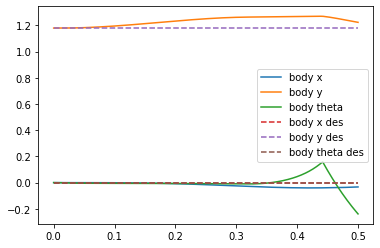

In [184]:
keypoint_hist_np = np.array(result['keypoints_hist'])
print()
ax = plt.subplot()
ax.plot(ts, keypoint_hist_np[:, 0, 0], label='body x')
ax.plot(ts, keypoint_hist_np[:, 0, 1], label='body y')
ax.plot(ts, result['ori_hist'], label='body theta')
ax.plot(ts, x_des_trj[0, :], '--', label='body x des')
ax.plot(ts, x_des_trj[1, :], '--', label='body y des')
ax.plot(ts, x_des_trj[2, :], '--', label='body theta des')


ax.legend()
plt.show()

In [178]:
anim = visualize_robot(result, dt = 0.001, num_frames=100)
plt.close()
HTML(anim.to_html5_video())

ZeroDivisionError: ignored